In [2]:
import numpy as np
from matplotlib import pyplot as plt

# Problem 1

In [3]:
x,y,z=np.loadtxt('rand_points.txt').T

Let's check to see if we can spot the planes that the random points lie on.

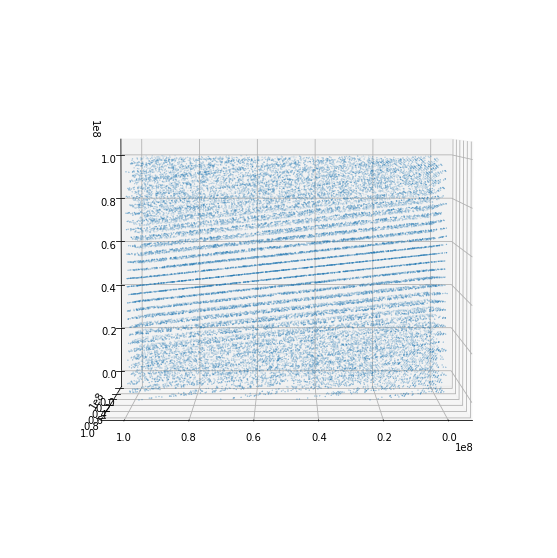

In [4]:
fig=plt.figure(figsize=(10,10))
ax=plt.axes(projection='3d')
ax.scatter(x,y,z,marker='.',s=0.2)
ax.view_init(3,90)

As expected, we see that the triples lie along planes. Let's check to see if python's random number generator suffers from the same shortcoming. 

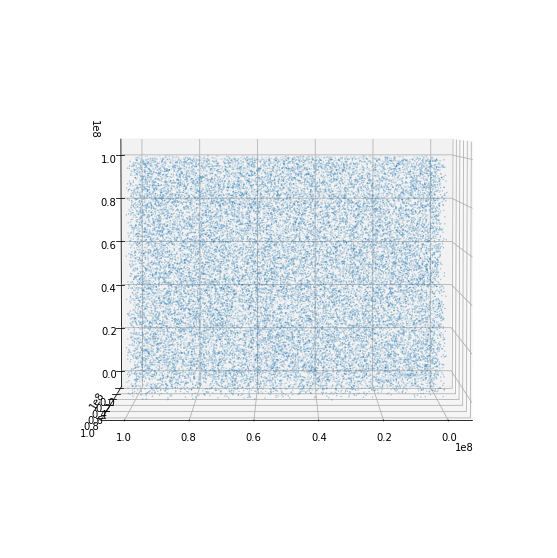

In [5]:
import random as rand

n=len(x)
x2,y2,z2=np.reshape(np.array([rand.uniform(0,1e8) for i in range(3*len(x))]),[len(x),3]).T

fig=plt.figure(figsize=(10,10))
ax=plt.axes(projection='3d')
ax.scatter(x2,y2,z2,marker='.',s=0.2)
ax.view_init(3,90)

Although we haven't checked all 3d orientations, it appears that python's random number generator does not have the same issue as C. My computer crashed when I tried to run the code on my computer, so I could not check the result locally.

# Problem 2

A gaussian goes like $e^{-x^2}$ and will decay faster than an exponential $e^{-x}$ for large $x$ so we will only use Lorentzians and power laws as bounding distributions.

The CDF of a power law is

$$ u(x) = 1-\left(\frac{x}{x_{min}}\right)^{1-\alpha}, $$

according to wikipedia. Inverting the CDF gives

$$ x=x_{min}(1-u)^{\frac{1}{1-\alpha}}.$$

We already derived the inverse CDF of a Lorentzian in class, which is

$$ x = \tan\left[\pi\left(u-\frac{1}{2}\right)\right] $$

In [287]:
# power law and lorentzian functions and inverse CDFs

def plaw(x,a):
    return (x)**-a

def inv_cdf_plaw(n,a,xmin):
    u=np.random.uniform(0,1,n)
    return xmin*(1-u)**(1/(1-a))

def lorentz(x):
    return 1/(1+x**2)

def inv_cdf_lorentz(n):
    return np.tan(np.pi*(np.random.rand(n)-0.5))

<ipython-input-288-6e814d1d1f1e>:8: RuntimeWarning: overflow encountered in exp
  exp=x_lorentz[y<np.exp(-x_lorentz)]


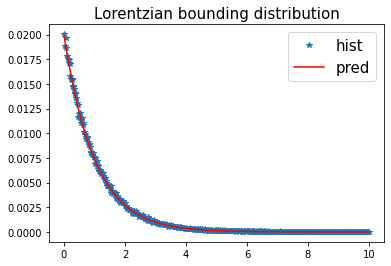

Acceptance fraction = 0.615132


In [288]:
#compute random lorentzian points
x_start,x_end=0.001,10
n=1000000
x_lorentz=inv_cdf_lorentz(n)
y=lorentz(x_lorentz)*np.random.rand(n)*2

#accept points below exponential
exp=x_lorentz[y<np.exp(-x_lorentz)]

#bin points
bins=np.linspace(x_start,x_end,501)
aa,bb=np.histogram(exp,bins)
cents=0.5*(bins[1:]+bins[:-1])
aa=aa/aa.sum()
pred=np.exp(-cents)
pred=pred/pred.sum()
plt.plot(cents,aa,'*',label='hist')
plt.plot(cents,pred,'r',label='pred')
plt.title('Lorentzian bounding distribution',fontsize=15)
plt.legend(fontsize=15)
plt.show()

print('Acceptance fraction =',len(exp)/len(y))

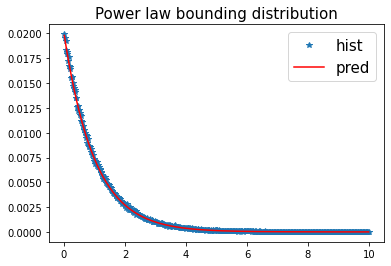

Acceptance fraction = 0.025101


In [289]:
#compute random power law points
x_start,x_end=0.001,10
n=10000000
a=1.1
x_plaw=inv_cdf_plaw(n,a,x_start)
y=plaw(x_plaw,a)*np.random.rand(n)*2

#accept points below exponential
exp=x_plaw[y<np.exp(-x_plaw)]

#bin points
bins=np.linspace(x_start,x_end,501)
aa,bb=np.histogram(exp,bins)
cents=0.5*(bins[1:]+bins[:-1])
aa=aa/aa.sum()
pred=np.exp(-cents)
pred=pred/pred.sum()
plt.plot(cents,aa,'*',label='hist')
plt.plot(cents,pred,'r',label='pred')
plt.title('Power law bounding distribution',fontsize=15)
plt.legend(fontsize=15)
plt.show()

print('Acceptance fraction =',len(exp)/len(y))

To understand why the Lorentzian bounding distribution has a far better acceptance fraction than the power law, we can look at the distributions.

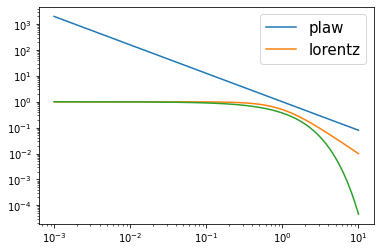

In [290]:
x=np.linspace(x_start,x_end,10000)
a=1.1
plt.loglog(x,plaw(x,a),label='plaw')
plt.loglog(x,lorentz(x),label='lorentz')
plt.loglog(x,np.exp(-x))
plt.legend(fontsize=15)
plt.show()

Since the power law diverges as $x\to0,$ many points are rejected at low $x.$ The Lorentzian tighly bounds the exponential in comparison, so it is better suited as a bounding distribution. Let's see if we can improve the acceptance fraction by changing the Lorentzian function. We will take

$$ f(x) = \frac{1}{1+(bx)^2}. $$

The CDF is then

$$ x = \frac{1}{b}\tan\left[\pi\left(u-\frac{1}{2}\right)\right] $$

In [291]:
#better Lorentzian function and inverse CDF

def better_lorentz(x,b):
    return 1/(1+(b*x)**2)

def better_inv_cdf(n,b):
    return b**-1*inv_cdf_lorentz(n)

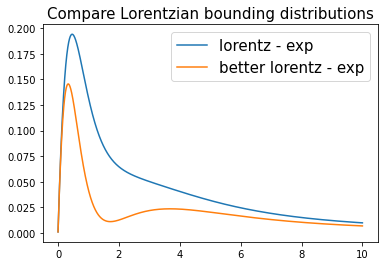

In [292]:
x=np.linspace(x_start,x_end,10000)
plt.plot(x,lorentz(x)-np.exp(-x),label='lorentz - exp')
plt.plot(x,better_lorentz(x,1.2)-np.exp(-x),label='better lorentz - exp')
plt.title('Compare Lorentzian bounding distributions',fontsize=15)
plt.legend(fontsize=15)
plt.show()

We have tightened the Lorentzian bounding distribution by introducing the $b$ factor. We should see an increase in the acceptance fraction.

<ipython-input-293-3902303fdaa3>:9: RuntimeWarning: overflow encountered in exp
  exp=x_lorentz[y<np.exp(-x_lorentz)]


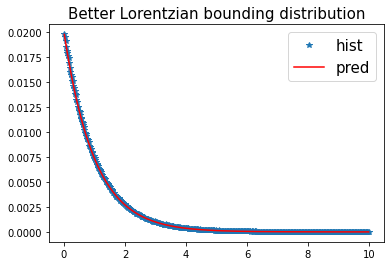

Acceptance fraction = 0.6417388


In [293]:
#compute random power law points
x_start,x_end=0.001,10
n=10000000
b=1.2
x_lorentz=better_inv_cdf(n,b)
y=better_lorentz(x_lorentz,b)*np.random.rand(n)*2

#accept points below exponential
exp=x_lorentz[y<np.exp(-x_lorentz)]

#bin points
bins=np.linspace(x_start,x_end,501)
aa,bb=np.histogram(exp,bins)
cents=0.5*(bins[1:]+bins[:-1])
aa=aa/aa.sum()
pred=np.exp(-cents)
pred=pred/pred.sum()
plt.plot(cents,aa,'*',label='hist')
plt.plot(cents,pred,'r',label='pred')
plt.title('Better Lorentzian bounding distribution',fontsize=15)
plt.legend(fontsize=15)
plt.show()

print('Acceptance fraction =',len(exp)/len(y))

We have improved the acceptance fraction by roughly $3\%.$ 

# Problem 3

We will now use a ratio-of-uniforms generator. Since we want $0<u<1,$ we have

$$ u \leq \sqrt{e^{-(v/u)}},$$

which gives

$$ v \leq -2u\log{u}. $$

In [378]:
#Find limits on v
u=np.linspace(0,1,2001)
u=u[1:]
v=-2*u*np.log(u)
print(v.min(),'<= v <=',v.max())

-0.0 <= v <= 0.7357588428385197


<ipython-input-380-bf85421921a6>:8: RuntimeWarning: overflow encountered in exp
  accept=u<np.exp(-x)**0.5


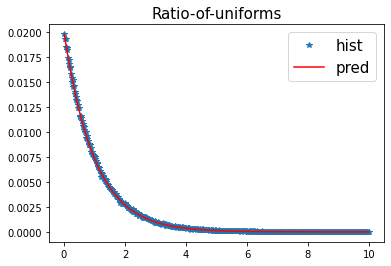

Acceptance fraction = 0.840267


In [380]:
#ratio-of-uniforms
n=1000000
u=np.random.rand(n)
v=(2*np.random.rand(n)-1)*v.max() #v values range from 0 to v
x=v/u

#accept values below root of exp
accept=u<np.exp(-x)**0.5
exp=x[accept]

#bin points
bins=np.linspace(x_start,x_end,501)
aa,bb=np.histogram(exp,bins)
cents=0.5*(bins[1:]+bins[:-1])
aa=aa/aa.sum()
pred=np.exp(-cents)
pred=pred/pred.sum()
plt.plot(cents,aa,'*',label='hist')
plt.plot(cents,pred,'r',label='pred')
plt.legend(fontsize=15)
plt.title('Ratio-of-uniforms',fontsize=15)
plt.show()

print('Acceptance fraction =',len(exp)/len(x))

The ratio-of-uniforms generator is $20\%$ more efficient than the Lorentzian bounding distribution.